In [1]:
! pip install -q pandas matplotlib scikit-learn openai dotenv tqdm liqfit sentencepiece transformers

import sys
print("Current python version: ", sys.version)

import pandas as pd
import matplotlib.pyplot as plt
import re
import datasketch

Current python version:  3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]


# Prepare supreme courts data for labeling 

In [2]:
# read parquet file
df = pd.read_parquet('../data/2024-supreme-court-decisions.parquet')
df.head()

,id,text
0,116067089,УХВАЛА\n\n29 грудня 2023 року\nм. Київ\nсправа...
1,116075955,УХВАЛА\nІМЕНЕМ УКРАЇНИ\n\n01 грудня 2023 року\...
2,116075956,У Х В А Л А\n\n01 грудня 2023 року\nм. Київ\n\...
3,116075957,УХВАЛА\n30 листопада 2023 року\nм. Київ\nсправ...
4,116075958,У Х В А Л А\n\n01 грудня 2023 року\nм. Київ\n\...


In [3]:
def prepare_text(text):
    # clear from consequent spaces (but not newlines)
    text = re.sub(r'[ \t]+', ' ', text)
    # clear from multiple newlines
    text = re.sub(r'\n+', '\n', text)
    text = text.strip()
    return text

df['text'] = df['text'].apply(prepare_text)
# trim to .01 and .99 quantiles
df = df[df['text'].str.len().quantile(0.01) <= df['text'].str.len()]
df = df[df['text'].str.len().quantile(0.99) >= df['text'].str.len()]

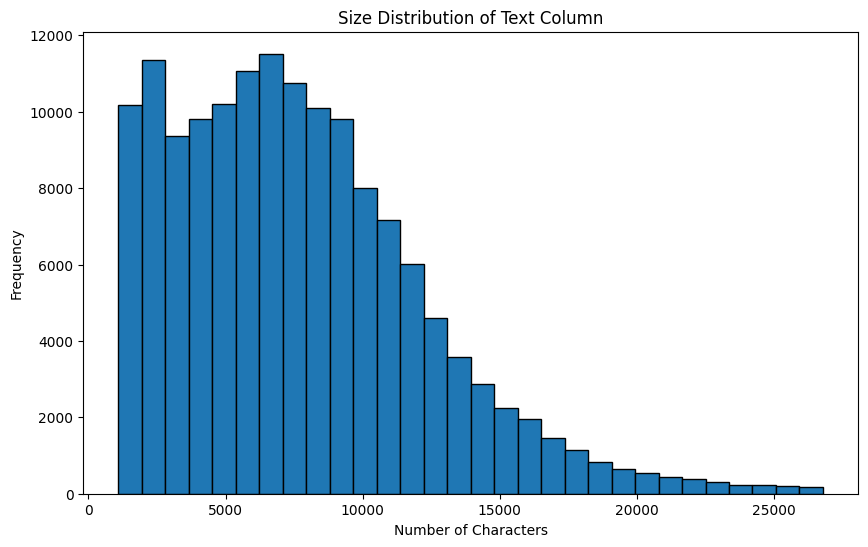

In [4]:
# Print size distribution of text column chart
plt.figure(figsize=(10, 6))
plt.hist(df['text'].str.len(), bins=30, edgecolor='black')
plt.title('Size Distribution of Text Column')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


In [5]:
# Limit to 1000/10000 charachters
df = df[df['text'].str.len() > 2_000]
df = df[df['text'].str.len() < 10_000]
df['text'].str.len().describe()

count    96783.000000
mean      5959.762076
std       2271.038592
min       2001.000000
25%       4032.000000
50%       6019.000000
75%       7865.000000
max       9999.000000
Name: text, dtype: float64

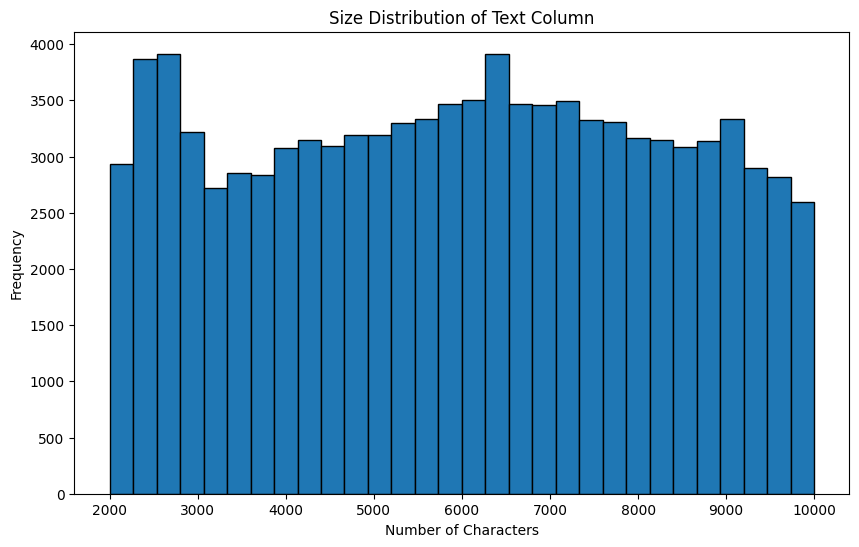

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df['text'].str.len(), bins=30, edgecolor='black')
plt.title('Size Distribution of Text Column')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [7]:
entites = {
    'НОМЕР_': 'number',
    'ІНФОРМАЦІЯ_': 'information',
    'ОСОБА_': 'person',
    'АДРЕСА_': 'address',
}

df['number_count'] = df['text'].str.count('НОМЕР_')
df['information_count'] = df['text'].str.count('ІНФОРМАЦІЯ_')
df['person_count'] = df['text'].str.count('ОСОБА_')
df['address_count'] = df['text'].str.count('АДРЕСА_')

# Limit to at least 1 occurrence of at least 2 of the counts
df['sum_of_unique_entities'] = df.apply(lambda row: sum([row['number_count'] > 0,  row['information_count'] > 0, row['person_count'] > 0, row['address_count'] > 0]), axis=1)


# Iterate documents and collect a list of occurrences of 'НОМЕР_' entity.
# Each occurance should have a text followed by 'НОМЕР_' entity.
# Include only 5 words before 'НОМЕР_' entity.
# Collect all the occurrences and save them to a file new column.


number_occurrences = []

df['number_occurrences'] = None
df['information_occurrences'] = None
df['person_occurrences'] = None
df['address_occurrences'] = None

for index, row in df.iterrows():
    text = row['text']
    
    
    for entity_name, entity_column in entites.items():
        unique_entities = set(re.findall(entity_name + '\d+', text))
        
        entity_occurrences = []

        for entity in unique_entities:
            # For each occurrence of entity, add start and end positions to the entity_occurrences dictionary
            entity_positions = [(m.start(), m.end()) for m in re.finditer(entity, text)]
            for start, end in entity_positions:
                entity_occurrences.append({
                    'start': start,
                    'end': end,
                    'text': entity
                })
    
        df.at[index, entity_column + '_occurrences'] = entity_occurrences


df_filtered = df[df['sum_of_unique_entities'] >= 2]
df_filtered.describe()

,number_count,information_count,person_count,address_count,sum_of_unique_entities
count,17968.000000,17968.000000,17968.000000,17968.000000,17968.000000
mean,2.814392,1.582536,11.059773,0.814837,2.195514
std,4.184813,3.011967,10.109744,2.123149,0.439984
min,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,4.000000,0.000000,2.000000
50%,0.000000,0.000000,8.000000,0.000000,2.000000
75%,5.000000,2.000000,15.000000,1.000000,2.000000
max,52.000000,37.000000,300.000000,137.000000,4.000000


In [37]:
# Run deduplication

def find_duplicates(df, threshold, num_perm=128):
    lsh = datasketch.MinHashLSH(threshold=threshold)
    duplicate_ids = []
    
    for index, row in df.iterrows():
        id = row['id']
        text = row['text']
        minhash = datasketch.MinHash(num_perm=num_perm)
        
        for word in text.lower().split():
            minhash.update(word.encode('utf-8'))

        result = lsh.query(minhash)
        if not result:
            lsh.insert(id, minhash)
        else:
            duplicate_ids.append(id)
            
    return duplicate_ids


thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    duplicate_ids = find_duplicates(df_filtered, threshold)
    print(f"Threshold: {threshold}, Duplicates: {len(duplicate_ids)}, Unique: {len(df_filtered) - len(duplicate_ids)}, Total: {len(df_filtered)}")

Threshold: 0.5, Duplicates: 16598, Unique: 1370, Total: 17968
Threshold: 0.6, Duplicates: 12843, Unique: 5125, Total: 17968
Threshold: 0.7, Duplicates: 9080, Unique: 8888, Total: 17968
Threshold: 0.8, Duplicates: 4803, Unique: 13165, Total: 17968
Threshold: 0.9, Duplicates: 1642, Unique: 16326, Total: 17968


In [10]:
# Filter out duplicates using threshold 0.8 which seems to reduce the dataset to optimal size
duplicate_ids = find_duplicates(df_filtered, threshold=0.6)
df_filtered_no_duplicates = df_filtered[~df_filtered['id'].isin(duplicate_ids)]
print(f"Original size: {len(df_filtered)}")
print(f"Size after deduplication: {len(df_filtered_no_duplicates)}")
print(f"Number of duplicates removed: {len(df_filtered) - len(df_filtered_no_duplicates)}")


Original size: 17968
Size after deduplication: 5125
Number of duplicates removed: 12843


In [11]:
df_filtered_no_duplicates.head()

,id,text,number_count,information_count,person_count,address_count,sum_of_unique_entities,number_occurrences,information_occurrences,person_occurrences,address_occurrences
3,116075957,УХВАЛА\n30 листопада 2023 року\nм. Київ\nсправ...,6,0,8,0,2,"[{'start': 3371, 'end': 3378, 'text': 'НОМЕР_1...",[],"[{'start': 504, 'end': 511, 'text': 'ОСОБА_1'}...",[]
7,116075961,УХВАЛА\n30 листопада 2023 року\nм. Київ\nсправ...,0,0,19,7,2,[],[],"[{'start': 300, 'end': 307, 'text': 'ОСОБА_1'}...","[{'start': 949, 'end': 957, 'text': 'АДРЕСА_1'..."
20,116075986,|\n||\nУХВАЛА\n01 січня 2024 року\nм. Київ\nсп...,0,1,16,0,2,[],"[{'start': 573, 'end': 585, 'text': 'ІНФОРМАЦІ...","[{'start': 192, 'end': 199, 'text': 'ОСОБА_1'}...",[]
21,116075987,УХВАЛА\n01 січня 2024 року\nм. Київ\nсправа № ...,0,1,21,0,2,[],"[{'start': 514, 'end': 526, 'text': 'ІНФОРМАЦІ...","[{'start': 188, 'end': 195, 'text': 'ОСОБА_1'}...",[]
22,116075988,|\n||\nУХВАЛА\n01 січня 2024 року\nм. Київ\nсп...,0,1,15,0,2,[],"[{'start': 555, 'end': 567, 'text': 'ІНФОРМАЦІ...","[{'start': 191, 'end': 198, 'text': 'ОСОБА_1'}...",[]


In [50]:
# Select 40 documents for labeling (with seed)
limit_of_entities_for_labeling = 9
df_supreme_court_for_labeling = df_filtered_no_duplicates[(df_filtered_no_duplicates['number_count'] < limit_of_entities_for_labeling) & (df_filtered_no_duplicates['number_count'] > 0) &
                                            (df_filtered_no_duplicates['information_count'] < limit_of_entities_for_labeling) & (df_filtered_no_duplicates['information_count'] > 0) &
                                            (df_filtered_no_duplicates['person_count'] < limit_of_entities_for_labeling) & (df_filtered_no_duplicates['person_count'] > 0) & 
                                            (df_filtered_no_duplicates['address_count'] < limit_of_entities_for_labeling) & (df_filtered_no_duplicates['address_count'] > 0)].sample(n=14, random_state=42)
df_supreme_court_for_labeling.to_csv('./supreme_court_for_labeling.csv', index=False)
df_supreme_court_for_labeling.head()

,id,text,number_count,information_count,person_count,address_count,sum_of_unique_entities,number_occurrences,information_occurrences,person_occurrences,address_occurrences
147907,124028233,УХВАЛА\n23 грудня 2024 року\nм. Київ\nсправа №...,2,1,8,2,4,"[{'start': 1352, 'end': 1359, 'text': 'НОМЕР_1...","[{'start': 1958, 'end': 1970, 'text': 'ІНФОРМА...","[{'start': 276, 'end': 283, 'text': 'ОСОБА_1'}...","[{'start': 1334, 'end': 1342, 'text': 'АДРЕСА_..."
46285,118464857,УХВАЛА\n17 квітня 2024 року\nм. Київ\nсправа №...,1,6,6,1,4,"[{'start': 1324, 'end': 1331, 'text': 'НОМЕР_1'}]","[{'start': 1176, 'end': 1188, 'text': 'ІНФОРМА...","[{'start': 333, 'end': 340, 'text': 'ОСОБА_1'}...","[{'start': 1266, 'end': 1274, 'text': 'АДРЕСА_..."
111899,121957732,УХВАЛА\n23 вересня 2024 року\nм. Київ\nсправа ...,1,6,1,1,4,"[{'start': 1817, 'end': 1824, 'text': 'НОМЕР_1'}]","[{'start': 264, 'end': 276, 'text': 'ІНФОРМАЦІ...","[{'start': 306, 'end': 313, 'text': 'ОСОБА_1'}]","[{'start': 1844, 'end': 1852, 'text': 'АДРЕСА_..."
114341,122118191,УХВАЛА\n07 жовтня 2024 року\nм. Київ\nсправа №...,1,1,8,3,4,"[{'start': 1378, 'end': 1385, 'text': 'НОМЕР_1'}]","[{'start': 1357, 'end': 1369, 'text': 'ІНФОРМА...","[{'start': 502, 'end': 509, 'text': 'ОСОБА_1'}...","[{'start': 1388, 'end': 1396, 'text': 'АДРЕСА_..."
56876,119045199,УХВАЛА\n10 травня 2024 року\nм. Київ\nсправа №...,1,1,5,2,4,"[{'start': 2370, 'end': 2377, 'text': 'НОМЕР_1'}]","[{'start': 2860, 'end': 2872, 'text': 'ІНФОРМА...","[{'start': 546, 'end': 553, 'text': 'ОСОБА_1'}...","[{'start': 2455, 'end': 2463, 'text': 'АДРЕСА_..."


# Load already labeled data

In [ ]:
df_supreme_court_labeled = pd.read_csv('../../experiments/df_labeled_supreme_court_40.csv')
df_supreme_court_labeled.head()



In [12]:
df_filtered_no_duplicates.to_parquet('../data/2024-supreme-court-decisions-deduplicated.parquet')